# Desafio Técnico PDI 

📌 **OBJETIVO** - Considerando que a imagem em questão (encarte de supermercado) será processada por algoritmos de PDI e NLP, você como desenvolverdor do time de processamento de imagens tem a missão de aplicar à imagem algoritmos de pré-processamentos com o objetivo de destacar as regiões de interesse sabendo que cada oferta (nome e preço do produto) serão extraídos pelo time de NLP. Agora é com você, dev PDI ! Dado a imagem em anexo, escreva um código para aplicar os melhores pré-processamentos possíveis, preparando a imagem para o time de NLP.

> NUVEN - Núcle de Visão Computacional e Engenharia

> Processo seletivo para a vaga **Desenvolvedor(a) em Processamento de Imagens**

> Andressa Gomes Moreira

**Importações**

In [2]:
#!pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25854 sha256=50de19498e6e31bda8488bbbe32deb4efd647bd8a52664741bc671e6bba711e3
  Stored in directory: c:\users\andre\appdata\local\pip\cache\wheels\c2\02\32\f3617a9f68bcc67eda3ebeb4514eba18f62e81ff439428109d
Successfully built imutils


In [327]:
import cv2
import numpy as np
import imutils
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
from PIL import Image

import pytesseract
pytesseract.pytesseract.tesseract_cmd = "C:\Program Files\Tesseract-OCR\Tesseract.exe"

**Carregamento da imagem analisada**

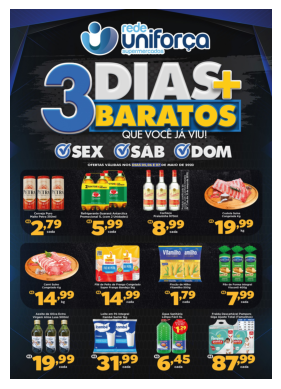

In [233]:
def carrega_imagem(path):
    """Carrega e exibe a imagem no formato RGB.

    Args:
        path (string): Caminho para imagem

    Returns:
        rgb: Retorna a imagem RGB
    """
    
    img = cv2.imread(path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(rgb);
    
    return rgb
    
rgb = carrega_imagem('./imagens/imagem_pdi.jpg')

In [234]:
rgb.shape

(2048, 1448, 3)

**Salvar as imagens**

In [235]:
def salva_imagem(path, img):
    """Salva a imagem processada no diretório.

    Args:
        path (string): Caminho para imagem
        img: Imagem resultante
    """
    cv2.imwrite(path, img)

### Pré-Processamento na imagem

**Área de Interesse**

> Primeiramente, é desejado gerar regiões de interesse (ROIs) da imagem (como nome e preço do produto) que serão extraídos em seguida.

In [236]:
def destaca_roi(img, rois):
    """Destaca as regiões de interesse (ROIs) da imagem.

    Args:
        img (numpy.ndarray - imagem): Imagem RGB
        rois (List): Coordenadas para destacar as regiões de interesse

    Returns:
        img_seg: Retorna a imagem segmentada
    """
        
    imagem_roi = np.zeros_like(img)

    for roi in rois:
        x, y, w, h = roi  # Caixa delimitadora: (x, y, w=largura, h=altura)
        img_aux = img[y:y+h, x:x+w]
        imagem_roi[y:y+h, x:x+w] = img_aux

    #altura, largura, _ = imagem_roi.shape
    #img_seg = imagem_roi[altura//2:altura, :]
    
    #plt.axis('off')
    #plt.imshow(imagem_roi);
    
    return imagem_roi

def segmenta_imagem(imagem_roi):
    altura, largura, _ = imagem_roi.shape
    img_seg = imagem_roi[altura//2:altura, :]
    
    plt.axis('off')
    plt.imshow(img_seg);
    
    return img_seg

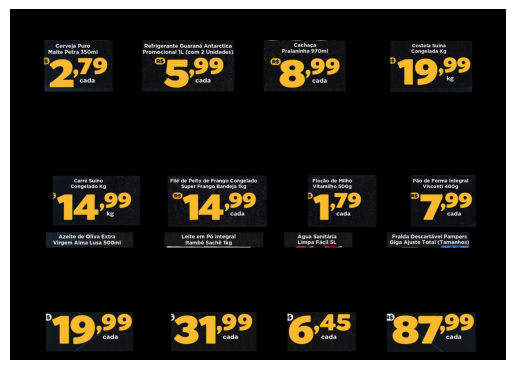

In [237]:
# Definir as coordenadas das ROIs
rois = [
    (100, 1115, 200, 150),  
    (385, 1115, 270, 150),  
    (740, 1115, 240, 150),
    (1110, 1117, 240, 150),

    (125, 1510, 255, 145),  
    (460, 1510, 290, 150),  
    (870, 1510, 200, 150),
    (1170, 1510, 190, 150),

    (105, 1675, 255, 45),  
    (450, 1675, 290, 45),  
    (800, 1675, 200, 45),
    (1100, 1675, 240, 45),

    (105, 1908, 255, 115),  
    (470, 1908, 250, 115), 
    (810, 1908, 200, 115),
    (1100, 1910, 260, 115),
]

img_seg = segmenta_imagem(destaca_roi(rgb, rois))

In [238]:
salva_imagem('./imagens/imagem_segmentada.jpg', cv2.cvtColor(img_seg, cv2.COLOR_RGB2BGR))

**Converter imagens para tons de cinza**

> A maioria dos algoritmos esperam uma imagem na escala de cinza, por isso será realizada a conversão da imagem RGB para tons de cinza.

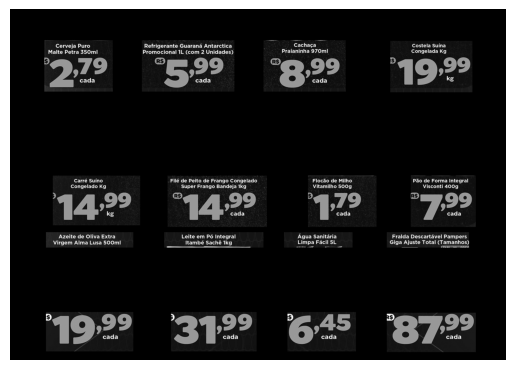

In [239]:
def converte_gray(img):
    """Converte a imagem RGB para tons de cinza.

    Args:
        img (numpy.ndarray - imagem): Imagem RGB

    Returns:
        rgb: Retorna a imagem em tons de cinza
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    plt.imshow(gray, cmap='gray');
    
    return gray

gray = converte_gray(img_seg)

In [150]:
gray.shape

(1024, 1448)

**Suavização da imagem**

> Para realizar a suavização da imagem e remover possíveis ruídos, será utilizado o filtro bilateral. O objetivo consiste em suavizar a imagem preservando os detalhes de bordas e contornos.	

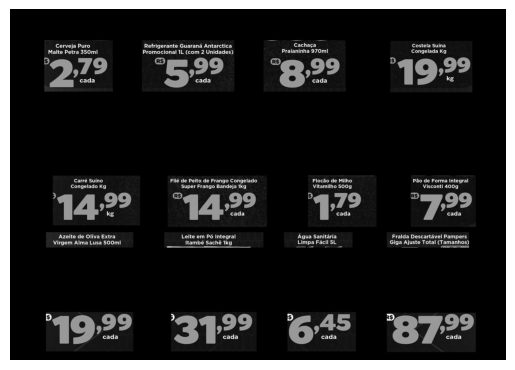

In [246]:
def suavizacao_bilateral(gray):
    """Realiza a suavização da imagem utilizando o filtro bilateral.

    Args:
        gray (numpy.ndarray - imagem): Imagem em tons de cinza

    Returns:
        img_suavizada: Retorna a imagem suavizada
    """
    
    img_suavizada = cv2.bilateralFilter(gray, 3, 75, 75) # cv2.GaussianBlur(gray, (3,3), 0)
    plt.axis('off')
    plt.imshow(img_suavizada, cmap='gray');
    
    return img_suavizada

img_suavizada = suavizacao_bilateral(gray)

**Binarização de Otsu**

> A binarização é realizada com objetivo de separar o objeto de interesse do fundo, podendo redefinir a região de interessa para a cor preta ou branca. Do contrário, o segundo plano é definido com a cor oposta. Foi utilizada a Binarização de Nobuyuki Otsu, na qual, é definido um limiar para realizar a binarização baseado no histograma da imagem.

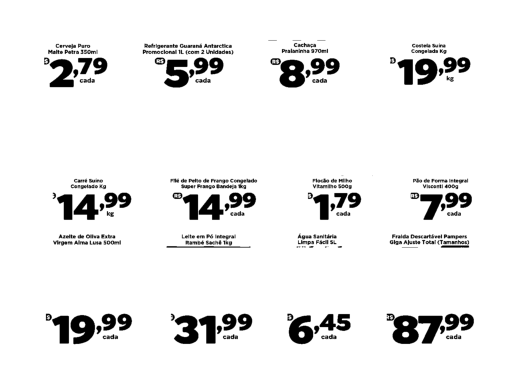

In [289]:
def binarizacao_otsu(img_suavizada):
    """Realiza a binarização da imagem pelo algoritmo Binarização de Nobuyuki Otsu.

    Args:
        img_suavizada (numpy.ndarray - imagem): Imagem suavizada em tons de cinza

    Returns:
        img_binarizada_otsu: Retorna a imagem binarizada
    """
    
    # Aplicar uma transformação de limiarização para segmentar os dígitos
    _, img_binarizada_otsu = cv2.threshold(img_suavizada, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    plt.axis('off')
    plt.imshow(img_binarizada_otsu, cmap='gray');
    
    return img_binarizada_otsu

img_binarizada_otsu = binarizacao_otsu(img_suavizada)

In [248]:
img_binarizada_otsu.shape

(1024, 1448)

In [249]:
cv2.imwrite('./imagens/imagem_binarizada_otsu.jpg', img_binarizada_otsu)

True

### Extração de caracteres

> Para realizar a extração de caracteres é possível utilizar duas técnicas (disponíveis nos notebooks 'numeros_cnn.py' e 'digitos_pytesseract,py'). Para facilitar vamos enviar apenas uma região de interesse para cada técnica.

> Para reconhecer as letras é possível usar a biblioteca pytesseract. A imagem já encontra-se no formato adequado para ser reconhecida.

In [330]:
def roi_pyt(img, coord):
    img_copy = img.copy()

    # Definir as coordenadas do ROI
    x, y, w, h = coord #380, 80, 290, 59 # Exemplo de coordenadas do ROI w, h

    # Cortar o ROI da imagem original
    roi = img_copy[y:y+h, x:x+w]

    # Redimensionar a imagem para o tamanho do ROI
    imagem_redimensionada = cv2.resize(roi, (w, h))

    # Exibir a imagem redimensionada
    plt.axis('off')
    plt.imshow(imagem_redimensionada, cmap='gray');
    
    print(f'Texto Extraído:\n\n {pytesseract.image_to_string(imagem_redimensionada)}')
    
    return imagem_redimensionada

Texto Extraído:

 Refrigerante Guarana Antarctica
Promoclonal 1L (com 2 Unidades)



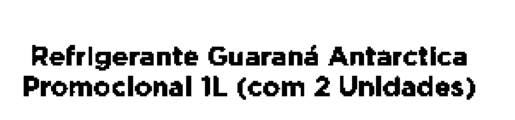

In [331]:
imagem_redimensionada1 = roi_pyt(img_binarizada_otsu, (380, 80, 290, 59))

Texto Extraído:

 Cerveja Puro
Malte Petra 350m!



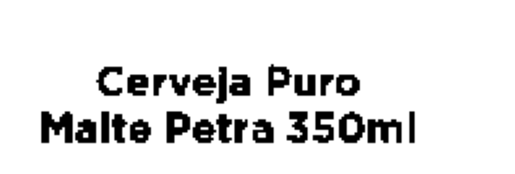

In [275]:
imagem_redimensionada2 = roi_pyt(img_binarizada_otsu, (100, 80, 190, 59))

Texto Extraído:

 Carré Suino
Congelado Kg



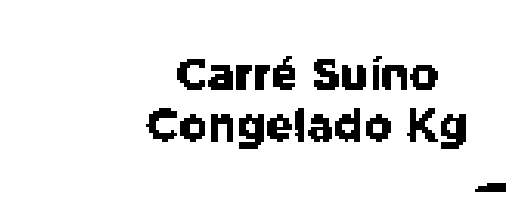

In [352]:
imagem_redimensionada3 = roi_pyt(img_binarizada_otsu, (133, 480, 160, 59))

Texto Extraído:

 Refrigerante Guarana Antarctica
De 1 X:) 2 1S”

99



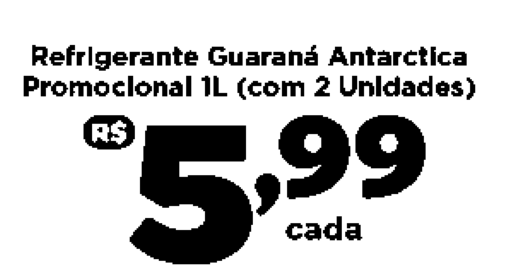

In [358]:
imagem_redimensionada1 = roi_pyt(img_binarizada_otsu, (380, 80, 290, 150))

**Preparação para rede neural**

In [ ]:
img_binarizada_otsu

**Inverte a imagem**

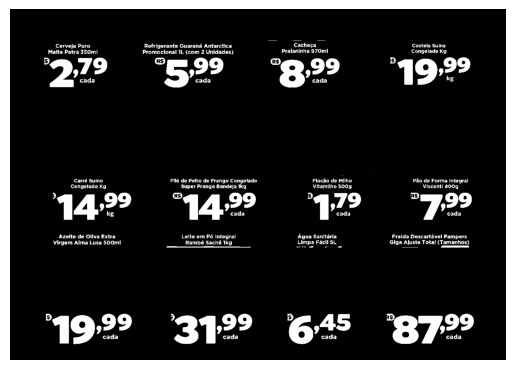

In [359]:
def inverte(img):
    """Realiza a inversão da imagem.

    Args:
        img (numpy.ndarray - imagem): Imagem binarizada

    Returns:
        img_inv: Retorna a imagem invertida
    """
    
    img_inv = 255 - img
    plt.axis('off')
    plt.imshow(img_inv, cmap='gray');
    
    return img_inv

img_inv = inverte(img_binarizada_otsu)

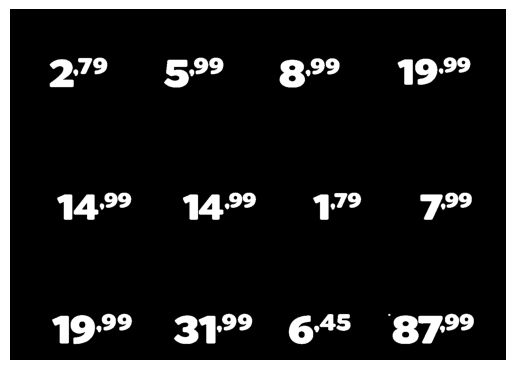

In [361]:
def abertura_imagem(img):
    """Aplica a operação morfológica abertura na imagem.

    Args:
        img: Imagem a ser processada
        
    Returns:
        img_abertura: Retorna a imagem após a operação de abertura
    """
    
    kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_abertura = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_ellipse)
    plt.axis('off')
    plt.imshow(img_abertura, cmap='gray');
    
    return img_abertura

img_abertura=abertura_imagem(img_inv)

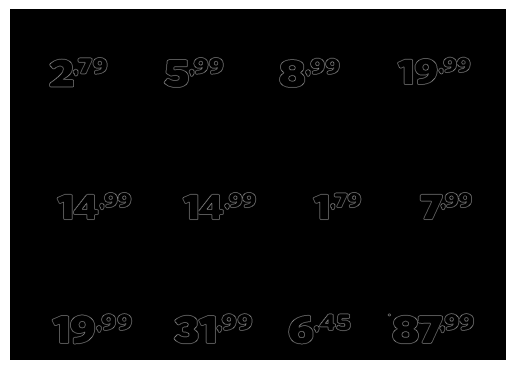

In [363]:
bordas = cv2.Canny(img_abertura, 40, 150)
plt.axis('off')
plt.imshow(bordas, cmap='gray');

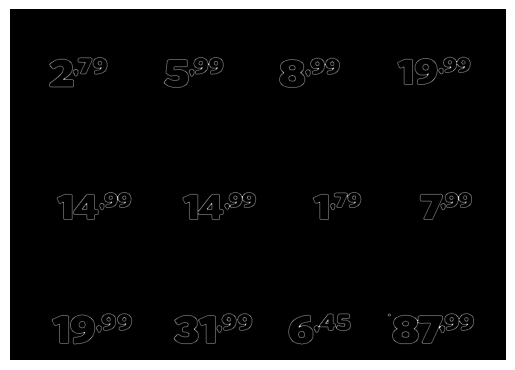

In [365]:
dilatado = cv2.dilate(bordas, np.ones((3,3)))
erosao = cv2.erode(dilatado, np.ones((3,3)))

plt.axis('off')
plt.imshow(erosao, cmap='gray');

Texto Extraído:

 {O22



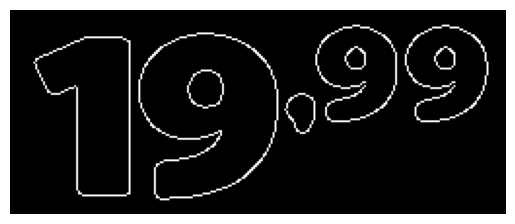

In [405]:
#imagem_redimensionada1 = roi_pyt(bordas, (770, 135, 200, 100))

imagem_redimensionada4 = roi_pyt(bordas, (110, 880, 255, 105))

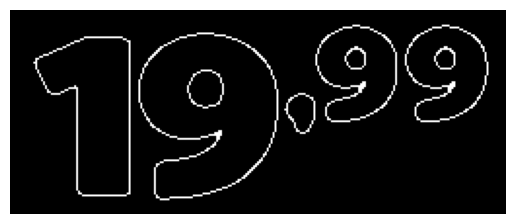

In [411]:
dilatado = cv2.dilate(imagem_redimensionada4, np.ones((3,3)))
erosao = cv2.erode(dilatado, np.ones((3,3)))
plt.axis('off')
plt.imshow(erosao, cmap='gray');

In [ ]:
salvar(imgimagem_redimensionada1)

In [412]:
cv2.imwrite('./imagens/imagem_redimensionada4.jpg', erosao)

True

In [296]:
img_binarizada_otsu.shape

(1024, 1448)

In [263]:
pytesseract.pytesseract.tesseract_cmd = "C:\Program Files\Tesseract-OCR\Tesseract.exe"
print(pytesseract.image_to_string(imagem_redimensionada1))

Refrigerante Guarana Antarctica
Promoclonal 1L (com 2 Unidades)



In [250]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = "C:\Program Files\Tesseract-OCR\Tesseract.exe"

In [251]:
pytesseract.pytesseract.tesseract_cmd = "C:\Program Files\Tesseract-OCR\Tesseract.exe"
print(pytesseract.image_to_string(img_binarizada_otsu))

Cerveja Puro Refrigerante Guarand Antarctica
ay 7 79 Premera us ‘9 2 o

19 99

Carré Suino Filé de Pelto de Frango Congelado
Congelade Kg on Frango 19 9

4,29 A

Azelte de Oliva Extra Lelte em Pé Integral
Virgem Alma Lusa 500m! Itambé Saché 1kg

B,

99 99

Cachaca
Praianinha 970m1

“@,99

cada

Flocdo de Milho
Vitamitho 79

hd

Agua Sanitaria
Limpa Facil SL

cada

Costeta Suina
Congelada Kg

Po de Forma Integral
Viscontl 99

199

Fralda Descartdvel Pampers
Glga Ajuste Total (Tamanhos)

199



**Inverte a imagem**

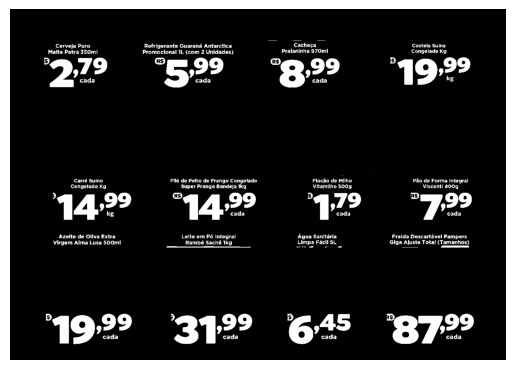

In [159]:
def inverte(img):
    """Realiza a inversão da imagem.

    Args:
        img (numpy.ndarray - imagem): Imagem binarizada

    Returns:
        img_inv: Retorna a imagem invertida
    """
    
    img_inv = 255 - img
    plt.axis('off')
    plt.imshow(img_inv, cmap='gray');
    
    return img_inv

img_inv = inverte(img_binarizada_otsu)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

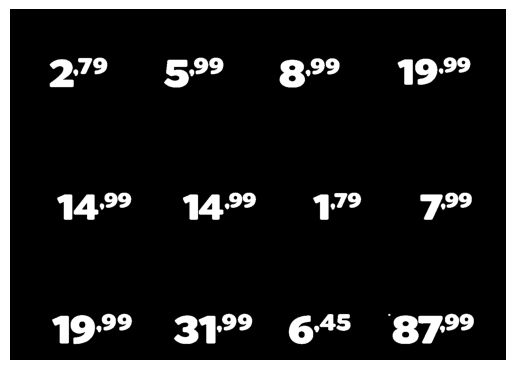

In [161]:
def abertura_imagem(img):
    """Aplica a operação morfológica abertura na imagem.

    Args:
        img: Imagem a ser processada
        
    Returns:
        img_abertura: Retorna a imagem após a operação de abertura
    """
    
    kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_abertura = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_ellipse)
    plt.axis('off')
    plt.imshow(img_abertura, cmap='gray');
    
    return img_abertura

abertura_imagem(img_inv)

**Binarização adaptativa gaussiana**

> A binarização é realizada com objetivo de separar o objeto de interesse do fundo, podendo redefinir a região de interessa para a cor preta ou branca. Do contrário, o segundo plano é definido com a cor oposta. Foi utilizada a binarização adaptativa, pois essa apresenta bons resultados para imagens que não possui uma boa iluminação (não é o caso da imagem em questão, mas o algoritmo se adaptou bem). São calculados diferentes valores de limiar para cada região da imagem.

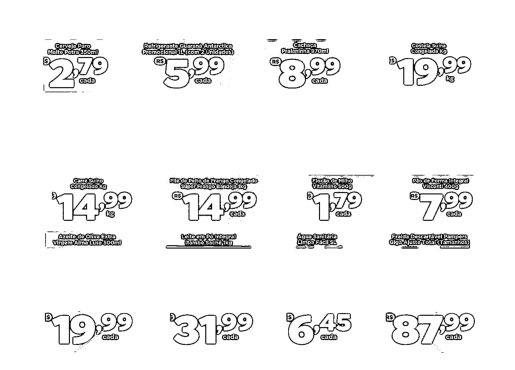

In [152]:
def binarizacao_adap_gaussiana(img_suavizada):
    """Realiza a binarização da imagem utilizando a binarização adaptativa gaussiana.

    Args:
        img_suavizada (numpy.ndarray - imagem): Imagem suavizada em tons de cinza

    Returns:
        img_binarizada: Retorna a imagem binarizada
    """
    
    img_binarizada =cv2.adaptiveThreshold(img_suavizada, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
    plt.axis('off')
    plt.imshow(img_binarizada, cmap='gray');
    
    return img_binarizada

img_binarizada = binarizacao_adap_gaussiana(img_suavizada)

In [128]:
# Aplicar uma transformação de limiarização para segmentar os dígitos
_, imagem_limiarizada = cv2.threshold(img_suavizada, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

In [129]:
cv2.imwrite('./imagens/imagem_bi.jpg', imagem_limiarizada)

True

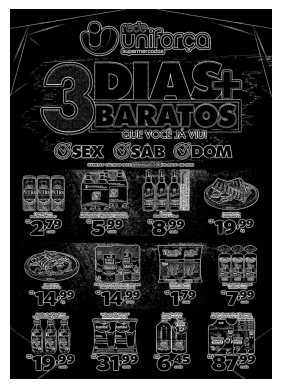

In [57]:
def inverte(img_binarizada):
    """Realiza a binarização da imagem utilizando a binarização adaptativa gaussiana.

    Args:
        img_binarizada (numpy.ndarray - imagem): Imagem binarizada

    Returns:
        img_inv: Retorna a imagem invertida
    """
    
    img_inv = 255 - img_binarizada
    plt.axis('off')
    plt.imshow(img_inv, cmap='gray');
    
    return img_inv

img_inv = inverte(img_binarizada)

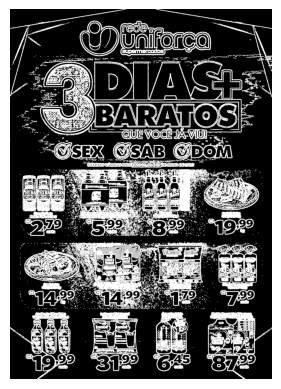

In [58]:
dilatado = cv2.dilate(img_inv, np.ones((3,3)))
plt.axis('off')
plt.imshow(dilatado, cmap='gray');

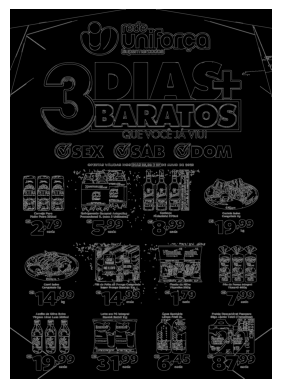

In [62]:
bordas = cv2.Canny(img_suavizada, 40, 150)
plt.axis('off')
plt.imshow(bordas, cmap='gray');

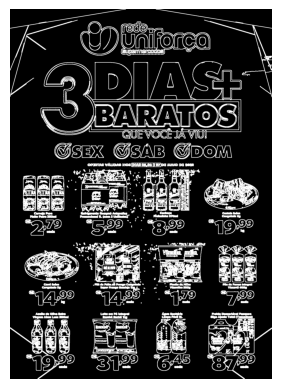

In [63]:
dilatado = cv2.dilate(bordas, np.ones((3,3)))
plt.axis('off')
plt.imshow(dilatado, cmap='gray');

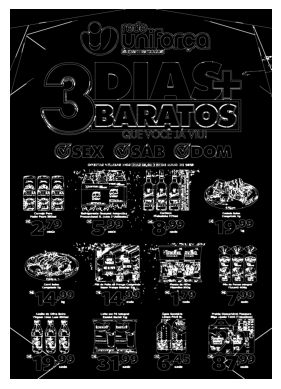

In [166]:
erosao = cv2.erode(dilatado, np.ones((3,3)))
plt.axis('off')
plt.imshow(erosao, cmap='gray');

def erosao_imagem(img):
    """Aplica a operação morfológica erosão.

    Args:
        img: Imagem
        
    Returns:
        img_erosao: Retorna a imagem após a operação de erosao
    """
    
    img_erosao = cv2.erode(img, np.ones((3,3)))
    plt.axis('off')
    plt.imshow(img_erosao, cmap='gray');
    
    return img_erosao
    
#img_erosao = salva_imagem(img_dilatado)

In [65]:

    
#salva_imagem('./imagens/imagem_erosao.jpg', erosao)